In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [3]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [ ]:
import scanpy as sc
import numpy as np 
import pandas as pd
# import anndata as ad
import yaml

In [4]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset9/"

# Data preparation

## SC data

In [ ]:
# Load exon counts
exon = pd.read_csv(data_path + "mouse_VISp_2018-06-14/exon-matrix.csv", index_col=0)   # genes x cells

In [ ]:
# make sparse
from scipy import sparse
exon_sparse = sparse.csr_matrix(exon.values)

In [ ]:
exon_sparse.shape  # genes x cells

(45768, 15413)

In [8]:
# Load gene and sample info
genes = pd.read_csv(data_path + "mouse_VISp_2018-06-14/genes-rows.csv", index_col=0)
samples = pd.read_csv(data_path + "mouse_VISp_2018-06-14/samples-columns.csv", index_col=0)

In [17]:
samples.shape[0]

15413

In [13]:
genes.head()

,gene_id,chromosome,gene_entrez_id,gene_name
gene_symbol,,,,
0610005C13Rik,500717483,7,71661,RIKEN cDNA 0610005C13 gene
0610006L08Rik,500717917,7,76253,RIKEN cDNA 0610006L08 gene
0610007P14Rik,500730104,12,58520,RIKEN cDNA 0610007P14 gene
0610009B22Rik,500726890,11,66050,RIKEN cDNA 0610009B22 gene
0610009E02Rik,500702775,2,100125929,RIKEN cDNA 0610009E02 gene


In [12]:
samples.head()

,sample_id,sample_type,organism,donor,sex,age_days,eye_condition,genotype,driver_lines,reporter_lines,...,genes_detected_cpm_criterion,genes_detected_fpkm_criterion,tdt_cpm,gfp_cpm,class,subclass,cluster,confusion_score,cluster_correlation,core_intermediate_call
sample_name,,,,,,,,,,,,,,,,,,,,,
F1S4_160108_001_A01,527128530,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,Ai14(RCL-tdT),...,10445,9222,248.86,248.86,GABAergic,Vip,Vip Arhgap36 Hmcn1,0.4385,0.837229,Intermediate
F1S4_160108_001_B01,527128536,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,Ai14(RCL-tdT),...,11600,10370,289.61,289.61,GABAergic,Lamp5,Lamp5 Lsp1,0.1025,0.878743,Core
F1S4_160108_001_C01,527128542,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,Ai14(RCL-tdT),...,11848,10734,281.06,281.06,GABAergic,Lamp5,Lamp5 Lsp1,0.0195,0.887084,Core
F1S4_160108_001_D01,527128548,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,Ai14(RCL-tdT),...,9494,8561,390.02,390.02,GABAergic,Vip,Vip Crispld2 Htr2c,0.2734,0.843552,Core
F1S4_160108_001_E01,527128554,Cells,Mus musculus,225675,M,53,Normal,Slc32a1-IRES-Cre/wt;Ai14(RCL-tdT)/wt,Slc32a1-IRES-Cre,Ai14(RCL-tdT),...,10012,8791,253.92,253.92,GABAergic,Lamp5,Lamp5 Plch2 Dock5,0.7532,0.854994,Core


In [19]:
# Build AnnData
adata_sc = sc.AnnData(X=exon_sparse.T, var=genes, obs=samples)
# adata_sc.var["gene_name"] = genes["gene_name"].values
# adata_sc.obs["barcode"] = samples.index.values
# adata_sc.var_names = adata_sc.var["gene_name"]
# adata_sc.obs_names = adata_sc.obs["barcode"]
adata_sc

AnnData object with n_obs × n_vars = 15413 × 45768
    obs: 'sample_id', 'sample_type', 'organism', 'donor', 'sex', 'age_days', 'eye_condition', 'genotype', 'driver_lines', 'reporter_lines', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'injection_label_direction', 'injection_primary', 'injection_secondary', 'injection_tract', 'injection_material', 'injection_exclusion_criterion', 'facs_date', 'facs_container', 'facs_sort_criteria', 'rna_amplification_set', 'library_prep_set', 'library_prep_avg_size_bp', 'seq_name', 'seq_tube', 'seq_batch', 'total_reads', 'percent_exon_reads', 'percent_intron_reads', 'percent_intergenic_reads', 'percent_rrna_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_synth_reads', 'percent_ecoli_reads', 'percent_aligned_reads_total', 'complexity_cg', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'tdt_cpm', 'gfp_cpm', 'class', 'subclass', 'cluster', 'confusion_score', 'cluster_correlation', 'core_intermediate_call'
    

In [27]:
(adata_sc.X.sum(axis=0) == 0).sum()

np.int64(3674)

Neither the number of cells, nor the number of genes (or non-zero genes) matches the benchmarking data shape.

In [28]:
# write
sc.write(filename=data_path + "scRNA_data.h5ad", adata=adata_sc, ext='h5ad')


## MERFISH data

In [13]:
# Load counts
counts = pd.read_csv(data_path + "MERFISH_Allen_VISp/fixed_1001844875.csv")
counts = counts.iloc[:, 2:]  # keep only expression columns

In [46]:
counts.head()

,1700022I11Rik,1810046K07Rik,5031425F14Rik,5730522E02Rik,Acta2,Adam2,Adamts2,Adamts4,Adra1b,Alk,...,Vwc2,Wipf3,Wnt7b,Zfp804b,area,position,total_reads,simpleClass,x_um,y_um
0,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,170.10,[1161.11337076 6178.3830543 ],870,67,1161.113371,6178.383054
1,0,0,1,1,0,0,0,0,0,0,...,9,1,0,1,206.55,[1162.91337076 6113.1330543 ],454,233,1162.913371,6113.133054
2,0,0,0,1,0,0,0,0,0,0,...,1,2,0,0,184.68,[1168.31337076 6046.0830543 ],269,97,1168.313371,6046.083054
3,0,0,0,0,2,0,0,0,0,0,...,3,0,0,0,87.48,[1163.81337076 6202.6830543 ],340,105,1163.813371,6202.683054
4,0,0,0,1,0,0,0,2,0,0,...,4,3,0,1,155.52,[1166.96337076 6083.8830543 ],241,72,1166.963371,6083.883054


In [24]:
# separate meta and counts
meta_cols = ['area', 'position', 'total_reads', 'simpleClass', 'x_um', 'y_um']
expr = counts.drop(columns=meta_cols)
obs = counts[meta_cols]

In [15]:
# Load gene info
genes = pd.read_csv(data_path + "MERFISH_Allen_VISp/MERFISH_genes.csv", index_col=0)
genes.head()

,gene
0,1700022I11Rik
1,1810046K07Rik
2,5031425F14Rik
3,5730522E02Rik
4,Acta2


In [112]:
genes.shape

(254, 1)

In [25]:
# get genes shared between gene df and counts columns
shared_genes = set(genes['gene']).intersection(counts.columns)
print(genes.shape[0] == len(shared_genes))  # all genes are in the cols


True


In [26]:
diff_cols = []
for col in counts.columns:
    if col not in shared_genes:
        diff_cols.append(col)
print(f"Other columns = {len(diff_cols)} : \n {diff_cols}")

Other columns = 20 : 
 ['Blank-1', 'Blank-10', 'Blank-2', 'Blank-3', 'Blank-4', 'Blank-5', 'Blank-6', 'Blank-7', 'Blank-8', 'Blank-9', 'Cd52', 'Igfbp6', 'Mup5', 'Rprml', 'area', 'position', 'total_reads', 'simpleClass', 'x_um', 'y_um']


We see that there are blank names, a few genes and the metadata already split, we remove the remaining from the expression dataframe:

In [27]:
expr = counts.drop(columns=diff_cols)
expr.shape

(2399, 254)

In [28]:
# Convert counts to sparse
from scipy import sparse
X = sparse.csr_matrix(expr.values)
X.shape

(2399, 254)

In [29]:
# Load spot data
spots_meta = pd.read_csv(data_path + "MERFISH_Allen_VISp/Allen_MERFISH_spots_with_anatomy.csv")
spots_meta = spots_meta.iloc[:, 2:]
print(spots_meta.shape)
spots_meta.head()


(3841412, 5)


,x_um,y_um,gene,depth_um,layer
0,1278.683956,6020.642260,Gad2,1445.701599,outside_VISp
1,1326.970330,6023.884788,Gad2,1403.168094,outside_VISp
2,1292.026844,6059.337093,Gad2,1413.731426,outside_VISp
3,1300.886241,6097.786264,Gad2,1385.680938,outside_VISp
4,1232.410068,6102.884182,Gad2,1440.812721,outside_VISp


This file contains single molecule/transcript information (3841412 rows).

In [30]:
# Build AnnData
adata_st = sc.AnnData(X=X, obs=obs, var=genes)
# adata.var["gene_name"] = genes["gene_name"].values
# adata.obs = spots_meta
adata_st.var_names = genes["gene"]
# adata.obs_names = counts.index.values  # spot IDs
adata_st.obsm['spatial'] = adata_st.obs[['x_um', 'y_um']]
adata_st

AnnData object with n_obs × n_vars = 2399 × 254
    obs: 'area', 'position', 'total_reads', 'simpleClass', 'x_um', 'y_um'
    var: 'gene'
    obsm: 'spatial'

THe orginal counts matrix matches the benchmarking paper data, but if we want to maintain only correcly named genes we have to losse some of them: from $268$ to $254$. The genes file likely lists only targeted biological genes, while the count matrix includes both genes and control probes.

In [33]:
# write
sc.write(filename=data_path + "MERFISH_data.h5ad", adata=adata_st, ext='h5ad')

# Data Loading

In [5]:
adata_sc = sc.read_h5ad(data_path + "scRNA_data.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 15413 × 45768
    obs: 'sample_id', 'sample_type', 'organism', 'donor', 'sex', 'age_days', 'eye_condition', 'genotype', 'driver_lines', 'reporter_lines', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'injection_label_direction', 'injection_primary', 'injection_secondary', 'injection_tract', 'injection_material', 'injection_exclusion_criterion', 'facs_date', 'facs_container', 'facs_sort_criteria', 'rna_amplification_set', 'library_prep_set', 'library_prep_avg_size_bp', 'seq_name', 'seq_tube', 'seq_batch', 'total_reads', 'percent_exon_reads', 'percent_intron_reads', 'percent_intergenic_reads', 'percent_rrna_reads', 'percent_mt_exon_reads', 'percent_reads_unique', 'percent_synth_reads', 'percent_ecoli_reads', 'percent_aligned_reads_total', 'complexity_cg', 'genes_detected_cpm_criterion', 'genes_detected_fpkm_criterion', 'tdt_cpm', 'gfp_cpm', 'class', 'subclass', 'cluster', 'confusion_score', 'cluster_correlation', 'core_intermediate_call'
    

In [34]:
adata_st = sc.read(data_path + "MERFISH_data.h5ad")  # .obsm['spatial'] contains affine coordinates
adata_st

AnnData object with n_obs × n_vars = 2399 × 254
    obs: 'area', 'position', 'total_reads', 'simpleClass', 'x_um', 'y_um'
    var: 'gene'
    obsm: 'spatial'

#### CT Annotations

In [35]:
print("scRNA cell types: \n", adata_sc.obs['subclass'].unique())
print("Spatial data cell types: \n", adata_st.obs['simpleClass'].nunique())
# common_cts = set(adata_sc.obs['celltype'].unique()) & set(adata_st.obs['celltype_mapped_refined'].unique())
# print("Common cell types: ", common_cts)

scRNA cell types: 
 ['Vip', 'Lamp5', 'Sst', 'Sncg', 'Serpinf1', ..., 'Low Quality', 'Doublet', 'VLMC', 'SMC', 'Batch Grouping']
Length: 28
Categories (28, object): ['Astro', 'Batch Grouping', 'CR', 'Doublet', ..., 'Sncg', 'Sst', 'VLMC', 'Vip']
Spatial data cell types: 
 39


# Config

In [ ]:
# Read config yaml
with open("data/Dataset9/train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed

{'cluster_label': 'subclass',
 'lambda_count': 1e-05,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

# Train/val split

In [37]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.seed(config['random_state'])
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

203 training genes:  ['ptprm' 'slco5a1' 'col25a1' 'marcksl1' 'rnf152' 'npy2r' 'gad2' 'dnase1l3'
 'pcdh8' 'vwc2'] ...
51 validation genes:  ['wnt7b' 'reln' 'slc25a13' 'cd14' 'moxd1' 'tnfaip6' 'trp53i11' 'ltf'
 'camk2d' 'prox1'] ...


# Model training

In [38]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 37.0 M | n/a  
---------------------------------------------------------
37.0 M    Trainable params
0         Non-trainable params
37.0 M    Total params
147.903   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([15413, 51])
G matrix shape: torch.Size([2399, 51])

Validation 0: {'val_score': 0.3413871228694916, 'val_sparsity-weighted_score': 0.008410420268774033, 'val_AUC': 0.46537259221076965, 'val_entropy': 0.9358929395675659}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 203 genes
S matrix shape: torch.Size([15413, 203])
G matrix shape: torch.Size([2399, 203])


Trainig:   0%|          | 1/1000 [00:23<6:25:54, 23.18s/it]

Epoch 0: {'loss': -2.9574105739593506, 'main_loss': 0.35146981477737427, 'vg_reg': 0.023531511425971985, 'kl_reg': 5.500088562371275e-08, 'entropy_reg': -0.00011226635979255661, 'l1_term': 2.9499696907464568e-08, 'l2_term': 3.6966808086846825e-11, 'sparsity_term': 0.44569724798202515, 'neighborhood_term': 0.521744430065155, 'getis_ord_term': 0.6173485517501831, 'moran_term': 0.00257136020809412, 'geary_term': 0.9951599836349487, 'ct_island_term': 4.823549915045078e-08}


Trainig:   5%|▌         | 50/1000 [17:47<5:38:52, 21.40s/it]


Validation 49: {'val_score': 0.366372674703598, 'val_sparsity-weighted_score': 0.00903597753494978, 'val_AUC': 0.5309109091758728, 'val_entropy': 0.7730646729469299}


Trainig:  10%|█         | 100/1000 [35:27<5:19:08, 21.28s/it]


Validation 99: {'val_score': 0.3305564820766449, 'val_sparsity-weighted_score': 0.008280803449451923, 'val_AUC': 0.5184614658355713, 'val_entropy': 0.34381070733070374}


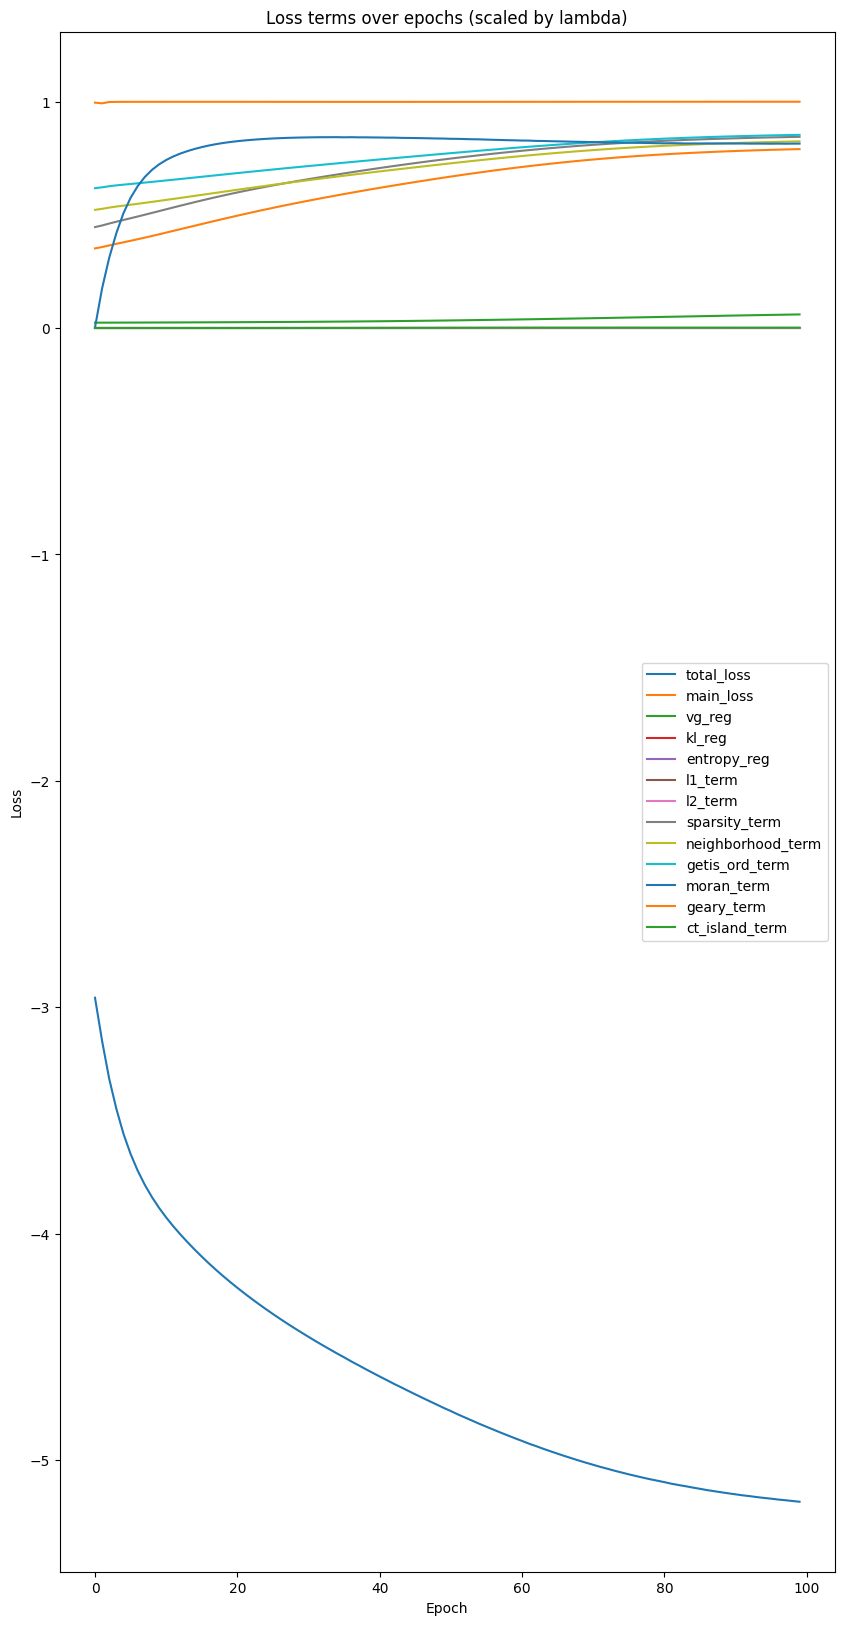

In [40]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True)

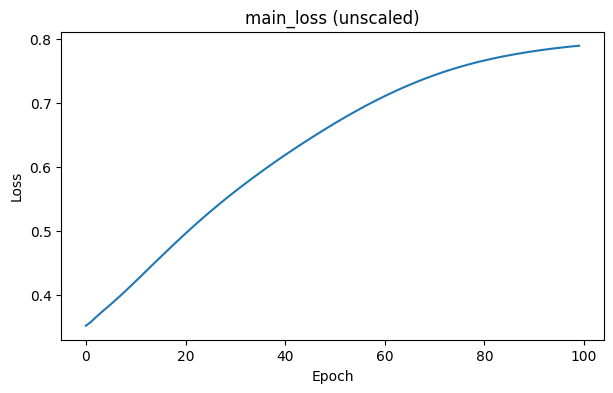

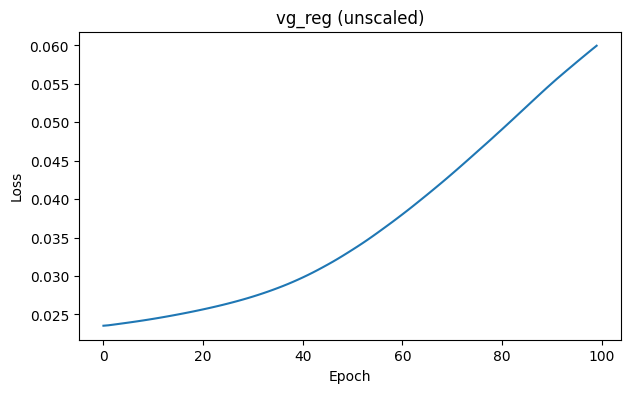

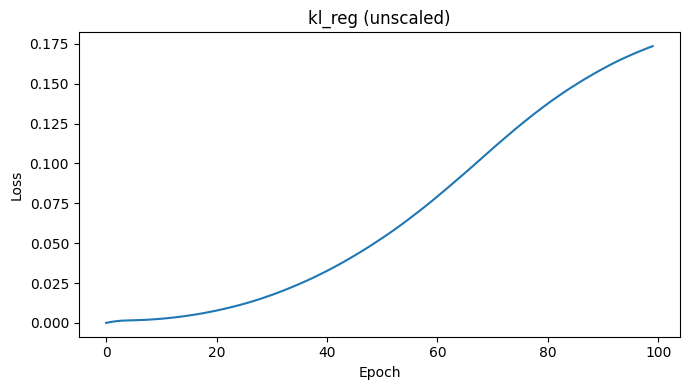

In [41]:
# Plot main loss
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "vg_reg", "kl_reg"], 
                   lambda_coeff = [1, 1, mapper.hparams.lambda_d], lambda_scale=False)

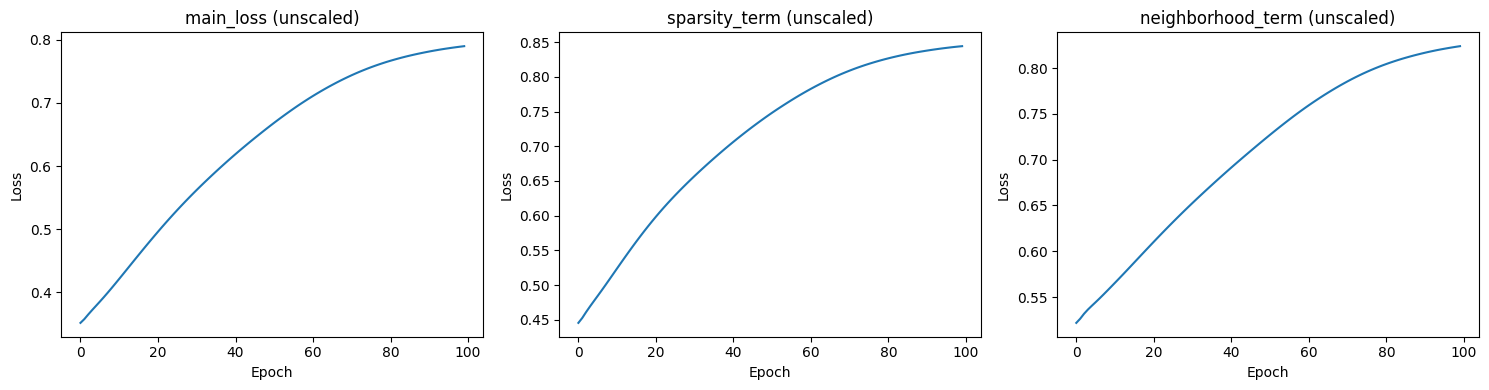

In [39]:
# Score terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "sparsity_term", "neighborhood_term"], lambda_scale=False,
                   make_subplot=True, subplot_shape=(1,3))

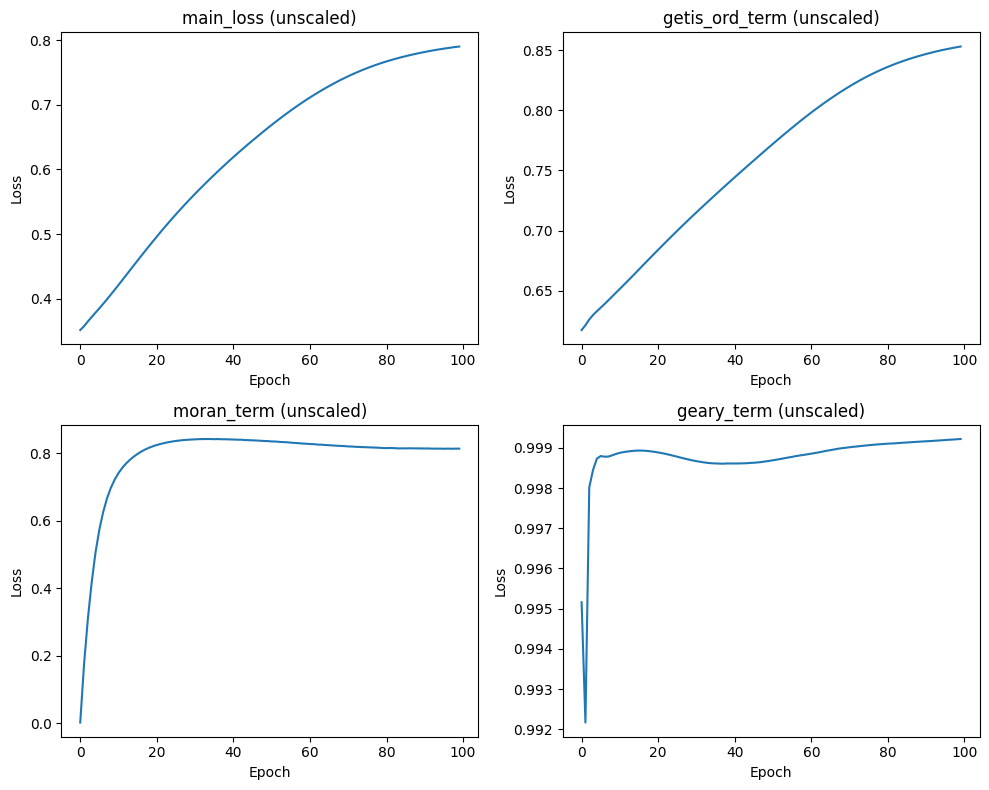

In [42]:
# LISA terms
tgl.plot_loss_terms(adata_map=ad_map, loss_key=["main_loss", "getis_ord_term", "moran_term", "geary_term"], 
                    lambda_scale=False, make_subplot=True)

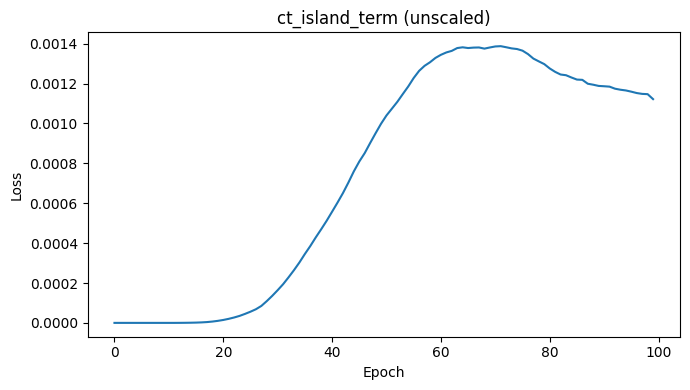

In [43]:
# CT islands term
tgl.plot_loss_terms(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

# Validation

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


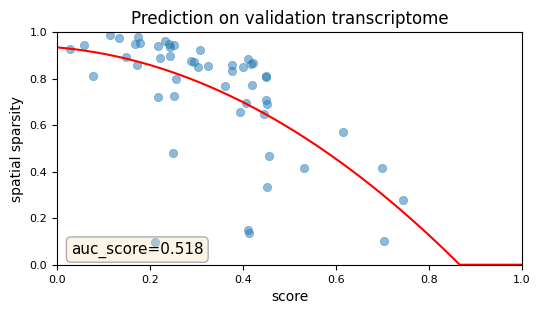

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.5184614658355713      │
│           val_JS            │     0.4298552870750427      │
│           val_PCC           │     0.16920867562294006     │
│          val_RMSE           │      1.285625696182251      │
│          val_SSIM           │     0.13692232966423035     │
│         val_entropy         │     0.34381070733070374     │
│          val_score          │     0.3305564820766449      │
│ val_sparsity-weighted_score │    0.008280803449451923     │
└─────────────────────────────┴─────────────────────────────┘

In [44]:
# call trainer.validate()
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

# Sparsity

In [46]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

AnnData object with n_obs × n_vars = 2399 × 45768
    obs: 'area', 'position', 'total_reads', 'simpleClass', 'x_um', 'y_um'
    var: 'gene_id', 'chromosome', 'gene_entrez_id', 'gene_name', 'sparsity', 'is_training'
    uns: 'overlap_genes', 'training_genes'

In [47]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

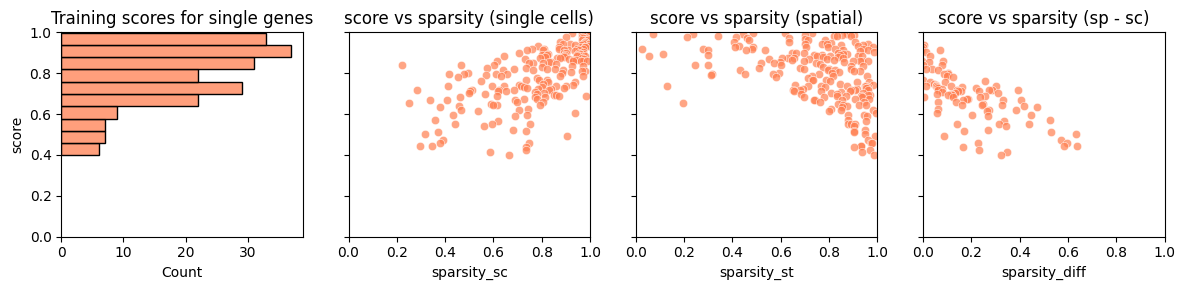

In [48]:
# Plot training scores panels
tgl.plot_training_scores(df)

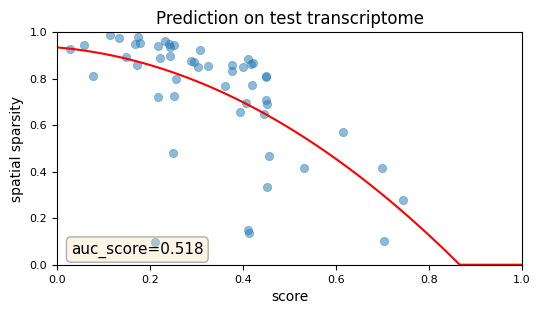

In [49]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)  # same as validation genes

# Save

In [ ]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_Dataset9', adata=ad_map, ext='h5ad')